# Solve a non-linear inverse problem with MCMC

We will solve a simple non-linear problem using MCMC, specifically the Parallel Tempering Algorithm with Two Chains.

We first define the forward model as $f(x) = x^2 + x$, where $x$ is a two-component vector and the $f()$ function is applied to each one of these components, giving another two-component vector.

In order to solve the inverse problem we must define two probability distributions:
- the prior and
- the likelihood

Both PDF will be Gaussian:

$$ p(x) = \frac{1}{\sqrt{2\pi} \sigma} \exp \{ SS(x) / 2\sigma^2 \} $$

For the prior, the $SS_{prior}(x)$ will be given by:

$$ SS_{prior}(x) = \sum_{i=1}^p \left( x_i - \nu_i \right)^2 $$

where $\nu$ is called the reference model.

And for the likelihood, the $SS(x)$ is defined as:

$$ SS(x) = \sum_{i=1}^N (y_i - f(x_i))^2 $$

where $f()$ is the forward model and $y$ is the collected data.

Multiplying these two PDFs we obtain the **posterior probability distribution**.
By applying the MCMC we want to sample this posterior and get its maximums, i.e. the models that best fit the data while taking into account the a priori information.

Next, we generate a synthetic model and compute the data it produces using the forward model and contaminate it with white noise.
We will expect the inverse problem to recover the synthetic model from this contaminated data.


## Inverse problem

When applying the Two Chains Parallel Tempering, we must define the following parameters:
- number of iterations,
- temperatures of the chains,
- probability to attempt a swap (equal to 0.5),
- standard deviation for the MCMC steps for each chain,
- standard deviation for the prior (we want it to be a high value),
- standard deviation for the likelihood (we want it to be a small value).

And finally we will set a reference model for the prior, i.e. the center of the prior Gaussian probability distribution, and a initial proposal for each chain.

Then we perform the parallel tempering algorithm. Each chain performs a Markov Chain independently of each other, i.e. they draw a trial point based on the previous one, compute acceptance rate and accept this new step with this probability.
Nevertheless, on every iteration we attempt to swap the current location of the chains with probability of 0.5. If this is the case we compute the $\alpha$ parameter (Sambridge, 2013) for the two chains and decide to exchange them with this probability.

We let the chains evolve until the maximum number of iterations is reached.
Finally we plot the results of the sampling in $R^2$, and the histograms and trace plots for each component of every chain.

We expect the lowest temperature chain to statistically recover the synthetic model. This means that the sampled points by this chain show a high point density around the parameters of the synthetic model.

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Define some functions

### Non linear forward model

In [2]:
def forward(model):
    """
    Compute forward model
    """
    return model ** 2 + model

### Prior probability distribution

In [3]:
def prior(model, reference_model, sigma):
    """
    Compute the prior PDF as a Gaussian function
    """
    ss_prior = sum((model - reference_model) ** 2)
    # We need the square root of ss_prior, because the first argument of stats.norm.pdf
    # will be powered to 2 when computing the PDF (see docstring of stats.norm.pdf)
    ss_prior = np.sqrt(ss_prior)
    return stats.norm.pdf(ss_prior, loc=0, scale=sigma)

### Likelihood probability distribution

In [4]:
def likelihood(data, data_predicted, sigma):
    """
    Compute the likelihood PDF as a Gaussian function
    """
    ss = sum((data - data_predicted) ** 2)
    # We need the square root of ss, because the first argument of stats.norm.pdf
    # will be powered to 2 when computing the PDF (see docstring of stats.norm.pdf)
    ss = np.sqrt(ss)
    return stats.norm.pdf(ss, loc=0, scale=sigma)

## Generate data from a synthetic model

In [5]:
# Define synthetic model
model_synth = np.array([2.5, 4])

# Compute data generated by the synthetic model with white noise
error = 0.1
data = forward(model_synth) + error * np.random.randn(2)

## Define parameters for the inverse problem

In [6]:
iterations = int(5e4)  # number of iterations
temperatures = [1, 20]  # temperatures of the chains
probability_of_swap = 0.5  # the probability to attempt a swap

# Standard deviations
sigma_mcmc = [0.1, 2]  # standard deviation for the MCMC steps for each chain
sigma_prior = 10  # standard deviation for the prior (we choose it to be big)
sigma_likelihood = 1  # standard deviation for the likelihood (we choose it small)

# Reference and first proposal models
reference_model = [0, 0]  # reference model used on the prior
start_model = np.array([-5, -5])  # model from which the MCMC will start (far from the synthetic)

## Initialize arrays and chains

In [7]:
n_chains = len(temperatures)  # get number of chains
models = np.zeros((n_chains, 2))  # array for models on each chain
probability = np.zeros(n_chains)  # probability for the model on each chain
sampled_points = np.empty((n_chains, iterations, 2))

for chain in range(n_chains):
    # Proposal
    models[chain, :] = start_model + sigma_mcmc[chain] * np.random.randn(2)
    # Compute probability of the proposed models on each chain
    probability[chain] = likelihood(
        data, forward(models[chain]), sigma_likelihood
    ) * prior(models[chain], reference_model, sigma_prior)

## Perform Parallel Tempering with two chains

In [8]:
for i in range(iterations):
    
    # Decide whether to swap chains or not
    if probability_of_swap > np.random.rand():
        # Compute alpha
        alpha = min(
            1,
            (probability[1] / probability[0]) ** (1 / temperatures[0])
            * (probability[0] / probability[1]) ** (1 / temperatures[1]),
        )
        # Decide if we should swap
        if alpha > np.random.rand():
            models[0, :], models[1, :] = models[1, :], models[0, :]
            probability[0], probability[1] = probability[1], probability[0]

    # Perform MCMC
    for chain in range(n_chains):
        model_trial = models[chain, :] + sigma_mcmc[chain] * np.random.randn(2)
        # Lets compute the posterior PDF
        probability_trial = likelihood(
            data, forward(model_trial), sigma_likelihood
        ) * prior(model_trial, reference_model, sigma_prior)
        # Compute the acceptance probability
        acceptance = min(
            1, (probability_trial / probability[chain]) ** (1 / temperatures[chain])
        )
        if acceptance > np.random.rand():
            models[chain, :] = model_trial
            probability[chain] = probability_trial
        # Add sampled points to array
        sampled_points[chain, i, :] = models[chain, :]

## Plot results

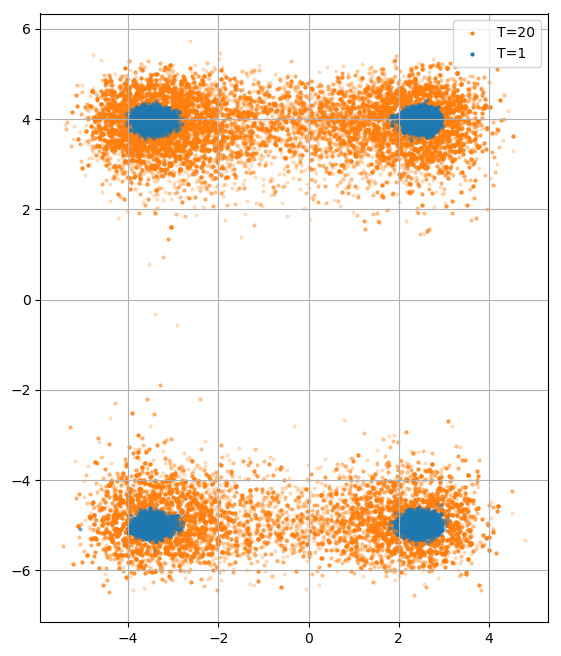

In [9]:
colors = ["C0", "C1"]
fig, ax = plt.subplots(figsize=(6.66, 6.66), dpi=100)

for chain in range(n_chains)[::-1]:
    ax.scatter(
        sampled_points[chain, :, 0],
        sampled_points[chain, :, 1],
        s=4,
        alpha=0.2,
        color=colors[chain],
        label="T={}".format(temperatures[chain]),
    )
ax.set_aspect("equal")
ax.grid()
legend = ax.legend()
for symbol in legend.legendHandles:
    symbol.set_alpha(1)  # make legend symbol non-transparent
fig.tight_layout()
plt.show()

### Plot histograms

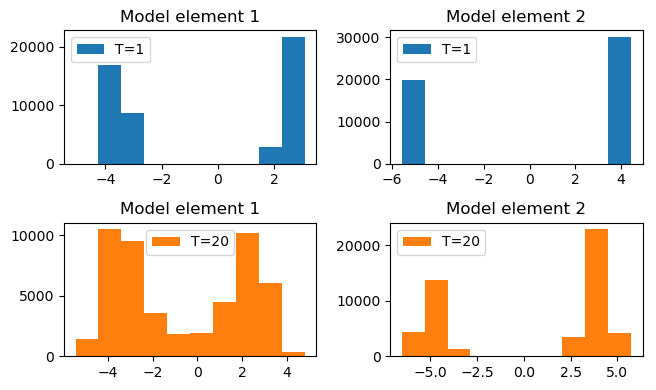

In [10]:
fig, axes = plt.subplots(nrows=n_chains, ncols=2, figsize=(6.66, 4), dpi=100)
for chain in range(n_chains):
    ax_row = axes[chain, :]
    for coordinate in range(2):
        ax_row[coordinate].hist(
            sampled_points[chain, :, coordinate],
            color=colors[chain],
            label="T={}".format(temperatures[chain]),
        )
        ax_row[coordinate].legend()
        ax_row[coordinate].set_title("Model element {}".format(coordinate + 1))
fig.tight_layout()
plt.show()

### Trace plots

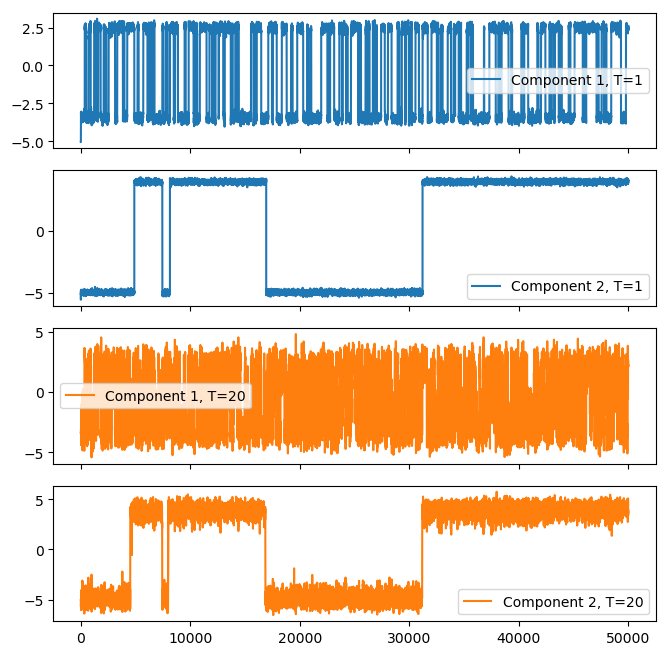

In [11]:
fig, axes = plt.subplots(
    nrows=2 * n_chains,
    ncols=1,
    sharex=True,
    figsize=(6.66, 6.66),
    dpi=100
)

i = 0
for chain in range(n_chains):
    for coordinate in range(2):
        axes[i].plot(
            sampled_points[chain, :, coordinate],
            color=colors[chain],
            label="Component {}, T={}".format(coordinate + 1, temperatures[chain]),
        )
        axes[i].legend()
        i += 1
fig.tight_layout()
plt.show()

## Conclusions

- We chose to increase the temperature of the second chain from 10 to 20 in order to make it capable of visiting more than one posterior maximum for a not-so-large number of iterations.
- The lowest temperature chain recovers four posterior maximums, being the synthetic model (2.5, 4) included.

## References

- Sambridge, M. (2013). A parallel tempering algorithm for probabilistic sampling and multimodal optimization. Geophysical Journal International, 196(1), 357-374.